**Project Video Links**:

Here is the Google Drive link for output files:  [Google Drive Link](https://drive.google.com/drive/folders/12tVX33lajukLVjKtaj2ePjrEfwp0gjxB)


Here is the project code:

##Install Dependencies

In [ ]:
!pip install -q ultralytics opencv-python

##Import Libraries & Load YOLOv8 Model

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os, time

# Load YOLOv8 model
model = YOLO('yolov8x.pt')
print("YOLOv8x model loaded successfully.")

YOLOv8x model loaded successfully.


##Setup Input/Output and Line Coordinates

In [ ]:
# Input video
video_path = "/content/people-walking.mp4"
cap = cv2.VideoCapture(video_path)

# Video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output directory and file
input_dir = os.path.dirname(video_path)
output_path = os.path.join(input_dir, "tracking_video_annotated.mp4")
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Line coordinates (from PolygonZone)
top_line = np.array([[1, 365], [1920, 365]])
bottom_line = np.array([[1, 625], [1920, 625]])
top_y, bottom_y = int(np.mean(top_line[:, 1])), int(np.mean(bottom_line[:, 1]))

# Tracking and counting variables
id_positions, id_states = {}, {}
in_count = out_count = frame_count = 0
tracker = 'bytetrack.yaml'
prev_time = time.time()

##People Tracking, Counting & Video Annotation

In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    results = model.track(frame, classes=[0], persist=True, tracker=tracker, verbose=False)
    boxes = results[0].boxes.xyxy.tolist()
    ids = results[0].boxes.id.int().tolist() if results[0].boxes.id is not None else []
    current_ids = set()

    # Draw lines
    cv2.line(frame, tuple(top_line[0]), tuple(top_line[1]), (255, 0, 0), 2)
    cv2.line(frame, tuple(bottom_line[0]), tuple(bottom_line[1]), (0, 0, 255), 2)

    # Loop over detections
    for box, track_id in zip(boxes, ids):
        x1, y1, x2, y2 = map(int, box)
        cx, cy = (x1 + x2)//2, (y1 + y2)//2
        current_ids.add(track_id)
        color = (255, 255, 255)  # Default white

        if track_id in id_positions:
            prev_y = id_positions[track_id]

            # IN: crosses top line downward
            if prev_y < top_y <= cy and id_states.get(track_id) != "in":
                in_count += 1
                id_states[track_id] = "in"
                print(f"In: ID {track_id}")

            # OUT: crosses bottom line upward
            elif prev_y > bottom_y >= cy and id_states.get(track_id) != "out":
                out_count += 1
                id_states[track_id] = "out"
                print(f"Out: ID {track_id}")

        # Update position
        id_positions[track_id] = cy

        # Color coding
        if id_states.get(track_id) == "in": color = (0, 255, 0)
        elif id_states.get(track_id) == "out": color = (0, 0, 255)

        # Draw person box & ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.circle(frame, (cx, cy), 5, color, -1)

    # Remove lost IDs
    lost_ids = set(id_positions.keys()) - current_ids
    for lost_id in lost_ids:
        id_positions.pop(lost_id, None)
        id_states.pop(lost_id, None)

    # FPS calculation
    curr_time = time.time()
    fps_live = 1 / (curr_time - prev_time)
    prev_time = curr_time

    # Display counters and stats
    cv2.putText(frame, f"In: {in_count}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(frame, f"Out: {out_count}", (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.putText(frame, f"FPS: {fps_live:.2f}", (20, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)
    cv2.putText(frame, f"Frame: {frame_count}", (20, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(frame, f"Active: {len(current_ids)}", (20, 140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2)

    out.write(frame)

cap.release()
out.release()

print(f"Tracking is complete. Saved video at: {output_path}")
print(f"Total In: {in_count}, Total Out: {out_count}")

In: ID 18
Out: ID 2
Out: ID 30
In: ID 11
In: ID 25
In: ID 27
In: ID 19
Out: ID 7
In: ID 20
In: ID 51
Out: ID 80
In: ID 9
Out: ID 102
Out: ID 103
In: ID 75
In: ID 79
In: ID 214
Out: ID 181
In: ID 33
Tracking is complete. Saved video at: /content/tracking_video_annotated.mp4
Total In: 12, Total Out: 7


##Heatmap Generation using YOLOv8

In [ ]:
# Config
video_path = '/content/people-walking.mp4'
output_heatmap_video = '/content/heatmap_output.mp4'
output_image_path = '/content/final_heatmap.jpg'
conf_threshold = 0.3


# Video setup
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("Could not read video.")

H, W = frame.shape[:2]
heatmap = np.zeros((H, W), dtype=np.float32)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_heatmap_video, fourcc, 30.0, (W, H))

# Process video
while ret:
    results = model(frame, verbose=False)[0]
    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if cls_id == 0 and conf > conf_threshold:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
            cv2.circle(heatmap, (cx, cy), radius=20, color=3, thickness=-1)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Overlay
    temp = np.clip(heatmap * 15, 0, 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(temp, (31, 31), 0)
    colored = cv2.applyColorMap(blurred, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.6, colored, 0.4, 0)
    out.write(overlay)
    ret, frame = cap.read()

cap.release()
out.release()

# Final heatmap
amp = np.clip(heatmap * 15, 0, 255)
norm = cv2.normalize(amp, None, 0, 255, cv2.NORM_MINMAX)
blur = cv2.GaussianBlur(norm.astype(np.uint8), (31, 31), 0)
color = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
cv2.imwrite(output_image_path, color)

print(f"Final heatmap saved at: {output_image_path}")
print(f"Heatmap video saved at: {output_heatmap_video}")

Final heatmap saved at: /content/final_heatmap.jpg
Heatmap video saved at: /content/heatmap_output.mp4


##Display the Final Heatmap

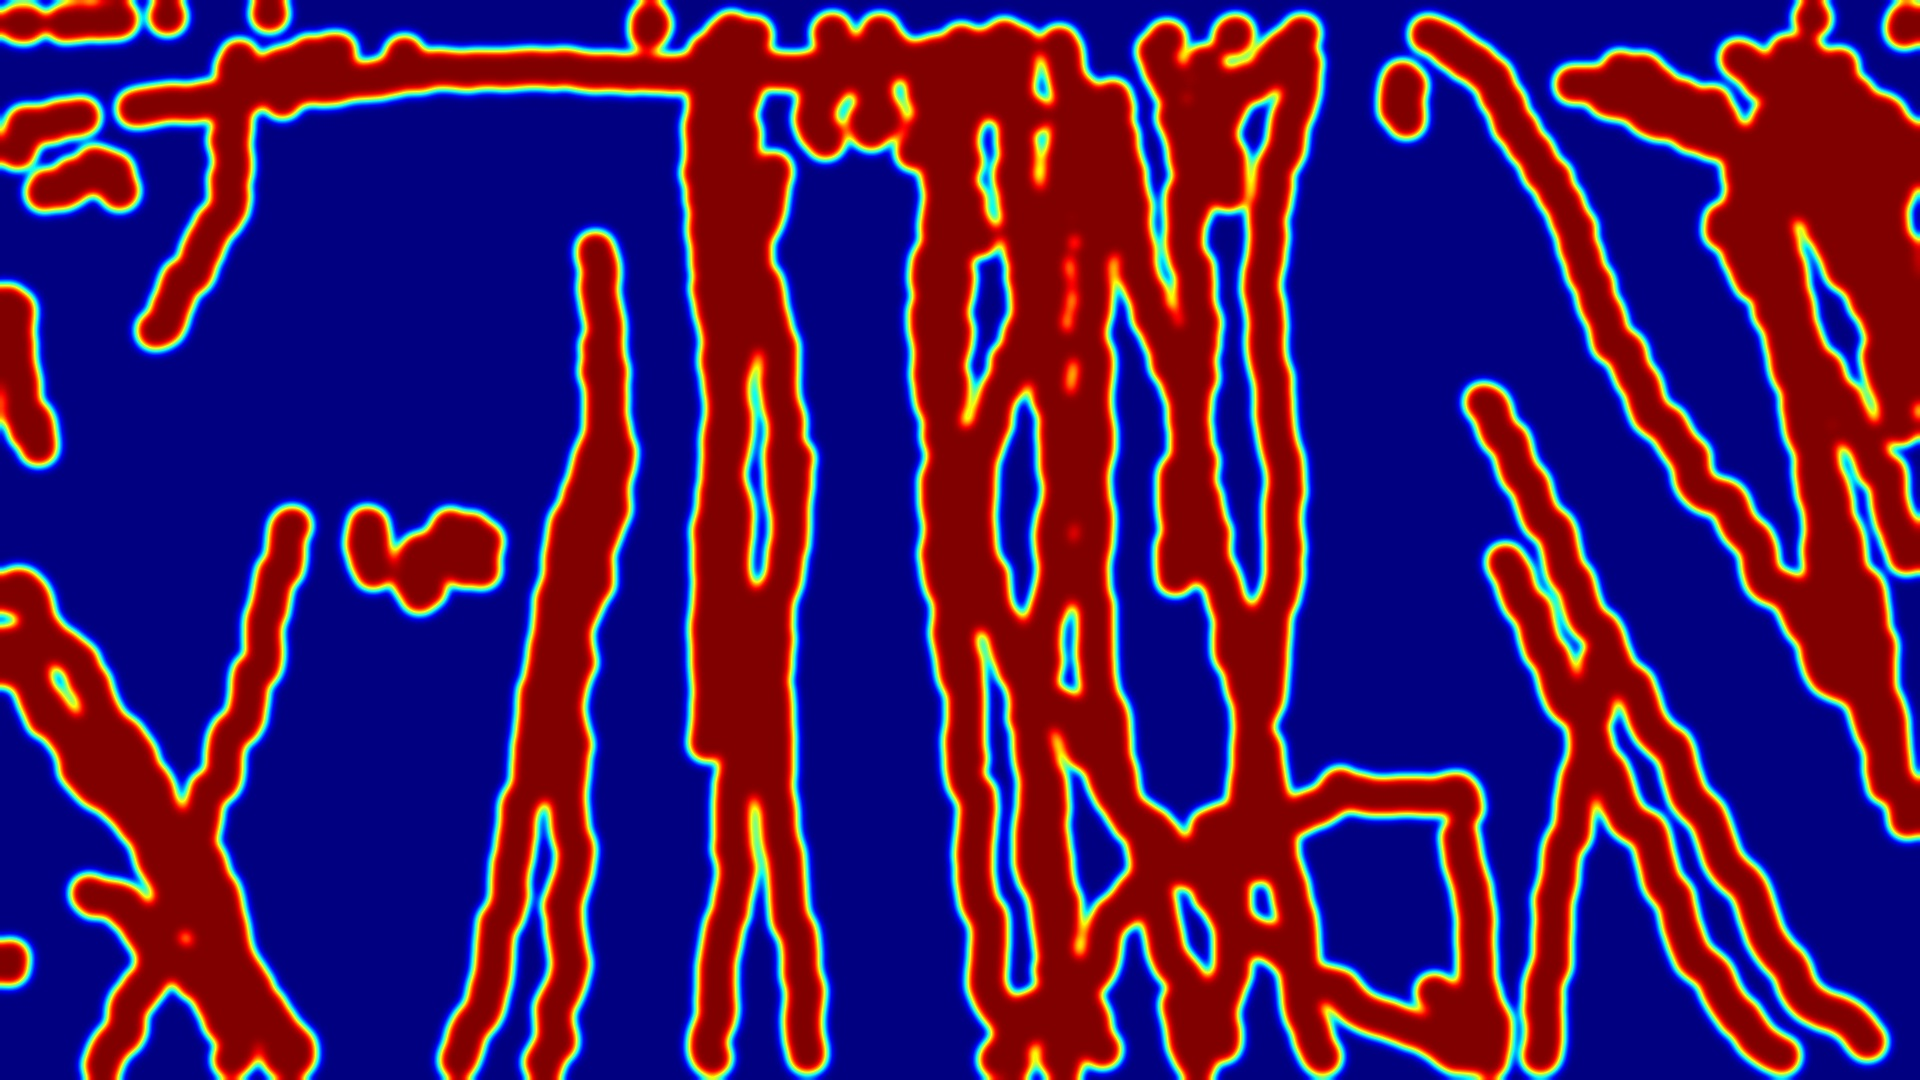

In [ ]:
from IPython.display import Image, display
display(Image('/content/final_heatmap.jpg', width=800))

In [ ]:

readme_content = """
# People Flow Detection & Heatmap Visualization

## Objective
This project tracks and counts people in a video using deep learning–based detection and tracking.
It classifies human movement as **IN** or **OUT** based on crossing two horizontal lines, and also generates a **motion heatmap** showing where people were most active in the scene.

---

## Detection Method

### 1. **People Detection**
- **Model:** YOLOv8x (from the Ultralytics library)
- **Purpose:** Detect only the *person* class (class ID = 0) from each video frame.
- **Why YOLOv8x?** It offers high accuracy and real-time performance, ideal for surveillance or flow analysis.

### 2. **Object Tracking**
- **Tracker Used:** ByteTrack (`bytetrack.yaml`)
- **Purpose:** Assigns a unique ID to each detected person and maintains identity across frames.
- **Why ByteTrack?** It is efficient, stable, and works well in crowded scenes.

### 3. **Counting Logic**
The system maintains a dictionary of object IDs with their previous Y-axis positions.
By comparing these positions with two predefined horizontal lines, it determines movement direction and updates counters.

---

## Line Coordinates (Defined Using PolygonZone)

| Line | Coordinates | Mean Y-value |
|------|--------------|--------------|
| **Top Line** | `[[1, 365], [1920, 365]]` | `top_y = 365` |
| **Bottom Line** | `[[1, 625], [1920, 625]]` | `bottom_y = 625` |

Both lines span the width of the video (1920 pixels), positioned at different vertical heights (Y = 365 and Y = 625).

---

## IN/OUT Logic Explanation

| Condition | Description | Count Updated | Visual Indicator |
|------------|--------------|----------------|------------------|
| **IN** | When a person moves **downward** (from above the top line) and crosses the **top line**. | `in_count += 1` | Green Box |
| **OUT** | When a person moves **upward** (from below the bottom line) and crosses the **bottom line**. | `out_count += 1` | Red Box |

**Implementation Insight:**
For each tracked person:
1. The system stores their previous vertical coordinate (`prev_y`).
2. If their direction indicates they crossed one of the lines, it marks them as “in” or “out” once.
3. Each person’s movement state is stored in a dictionary (`id_states`) to prevent double-counting.

---

## Heatmap Visualization

- **Purpose:** Highlights regions where people appeared most frequently.
- **Method:** For each detected person, the center point of their bounding box adds intensity to a 2D array.
- **Output:**
  - A **color heatmap** (`final_heatmap.jpg`) showing areas of dense movement.
  - A **heatmap video** (`heatmap_output.mp4`) showing real-time activity overlay.

---

## Setup (Google Colab)

1. Upload or link the video file:
   ```bash
   /content/people-walking.mp4
"""

In [ ]:
with open("README.md", "w") as f:
  f.write(readme_content)

In [ ]:
from IPython.display import Markdown, display

# Read the README.md content
with open("README.md", "r") as f:
    readme_text = f.read()

# Display as Markdown
display(Markdown(readme_text))


# People Flow Detection & Heatmap Visualization

## Objective
This project tracks and counts people in a video using deep learning–based detection and tracking.  
It classifies human movement as **IN** or **OUT** based on crossing two horizontal lines, and also generates a **motion heatmap** showing where people were most active in the scene.

---

## Detection Method

### 1. **People Detection**
- **Model:** YOLOv8x (from the Ultralytics library)  
- **Purpose:** Detect only the *person* class (class ID = 0) from each video frame.  
- **Why YOLOv8x?** It offers high accuracy and real-time performance, ideal for surveillance or flow analysis.

### 2. **Object Tracking**
- **Tracker Used:** ByteTrack (`bytetrack.yaml`)  
- **Purpose:** Assigns a unique ID to each detected person and maintains identity across frames.  
- **Why ByteTrack?** It is efficient, stable, and works well in crowded scenes.

### 3. **Counting Logic**
The system maintains a dictionary of object IDs with their previous Y-axis positions.  
By comparing these positions with two predefined horizontal lines, it determines movement direction and updates counters.

---

## Line Coordinates (Defined Using PolygonZone)

| Line | Coordinates | Mean Y-value |
|------|--------------|--------------|
| **Top Line** | `[[1, 365], [1920, 365]]` | `top_y = 365` |
| **Bottom Line** | `[[1, 625], [1920, 625]]` | `bottom_y = 625` |

Both lines span the width of the video (1920 pixels), positioned at different vertical heights (Y = 365 and Y = 625).

---

## IN/OUT Logic Explanation

| Condition | Description | Count Updated | Visual Indicator |
|------------|--------------|----------------|------------------|
| **IN** | When a person moves **downward** (from above the top line) and crosses the **top line**. | `in_count += 1` | Green Box |
| **OUT** | When a person moves **upward** (from below the bottom line) and crosses the **bottom line**. | `out_count += 1` | Red Box |

**Implementation Insight:**  
For each tracked person:
1. The system stores their previous vertical coordinate (`prev_y`).  
2. If their direction indicates they crossed one of the lines, it marks them as “in” or “out” once.  
3. Each person’s movement state is stored in a dictionary (`id_states`) to prevent double-counting.

---

## Heatmap Visualization

- **Purpose:** Highlights regions where people appeared most frequently.  
- **Method:** For each detected person, the center point of their bounding box adds intensity to a 2D array.  
- **Output:**  
  - A **color heatmap** (`final_heatmap.jpg`) showing areas of dense movement.  
  - A **heatmap video** (`heatmap_output.mp4`) showing real-time activity overlay.

---

## Setup (Google Colab)

1. Upload or link the video file:  
   ```bash
   /content/people-walking.mp4
